# Построение алгоритма бинарной классификации людей в хиджабе/без 

К положительному классу будем относить снимки, где присутствует хиджаб. К отрицательному - те, где он отсутствует на персонаже.

## Данные

Для работы использовались данные из следующих источников:

- Изображения людей в хиджабе, никабе и бурке. Фото были найдены по соответствующим запросам и выгружены вручную на сайтах https://unsplash.com/ (загрузка в один клик), https://www.pinterest.ru/ (загрузка в пару кликов) и https://www.google.com/search (загрузка в пару кликов). Всего было выгружено 500 изображений.
- Также были выгружены ~250 изображений мужчин и ~250 изображений женщин без хиджаба также из вышеупомянутых источников;

В итоге получился датасет, содержащий **547** изображение людей с непокрытым лицом и **500** изображений людей c покрытым лицом.
Ниже приведены примеры двух изображений для каждой из категорий.

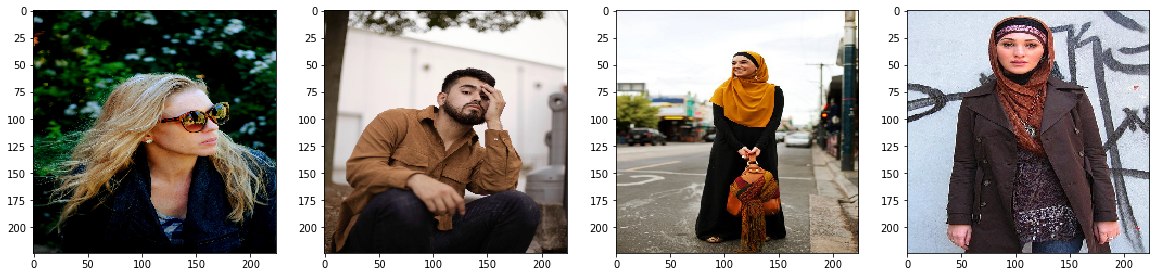

In [107]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import keras

plt.figure(figsize=(20,40))
names = ["data/total_neg/adalia-botha-Tsg7bwV0iTk-unsplash.jpg", "data/total_neg/alex-avalos-5rfIkuSXbH8-unsplash.jpg",
        "data/total_pos/0b833463e579b05ec5cafae39074e85a.jpg", "data/total_pos/cdca5a6a1530cc8e42bac9f364e8b567.jpg"]

for i, name in enumerate(names):
    plt.subplot(1, len(names), 1 + i)
    img = keras.preprocessing.image.load_img(name, target_size=(224, 224))
    x = image.img_to_array(img)
    plt.imshow(x / 255.0)

## Предобработка данных

- Разобьем изображения в две папки: соответственно **total_pos** и **total_neg**;
- Загрузка батчей с диска будет осуществляться в генераторе(DataGenerator);
- Данные будут загружаться посредством команды: $$keras.preprocessing.image.load\_img("<file\_name>", target\_size=(224, 224)),$$ при этом размер изображения станет равным (224х224х3) в результате работы алгоритма билинейной интерполяции;
- Также **в процессе обучения** в генераторе будут использованы техники Data Augmentation: параллельные сдвиги изображений в пределах 10% от горизонтального и вертикального размеров, а также повороты в пределах 10 градусов.

## Модель

Будем использовать классическую модель ResNet-50 в режиме **fine tuning** следующим образом:

- Загрузим ResNet-50 с параметрами, полученными посредством предобучения сети на датасете ImageNet;
- Отбросим последние Fully Connected слои;
- Добавим вместо отброшенных fully connected слоёв сперва **один 1х1-Conv слой с 20 фильтрами**, а затем **fully connected** слои с уменьшающейся от слоя к слою размерностью. В самом конце будет слой с двумя нейронами и softmax-функцией активации. Выходные значения данного слоя будут интерпретироваться как вероятности соответствующего класса;
- При этом обучать будем все обучаемые параметры полученной сети

В процессе обучения будет использоваться алгоритм оптимизации Adam. Важно правильно подобрать learning_rate, чтобы с одной стороны не обучаться слишком медленно, а с другой - не сильно нарушить имеющиеся паттерны предобученной сети. Эмпирическим путем было выбрано значение learning rate $10^{-5}$ .

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, Flatten, Dense
from keras.models import Model

def build_network(learning_rate = 1e-6):
    m = ResNet50(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))
    out = Conv2D(filters = 20, kernel_size = (1, 1), activation = 'relu')(m.output)
    out = Flatten()(out)
    out = Dense(200, activation = 'relu')(out)
    out = Dense(100, activation = 'relu')(out)
    out = Dense(50, activation = 'relu')(out)
    out = Dense(2, activation = 'softmax')(out)
    
    model = Model(inputs = m.input, outputs = out)
    model.compile(loss='binary_crossentropy',
                optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                metrics=['acc'])
    return model
   
model = build_network(learning_rate = 1e-5)
#model.summary()

## Разбиение данных на train/validation

Выберем случайным образом по 100 изображений из каждого класса на валидацию. Остальные изображения будут использованы для обучения

In [3]:
import os
import numpy as np

# Загружаем имена файлов
list_pos = os.listdir("data/total_pos")
list_neg = os.listdir("data/total_neg")


# Восстанавливаем полный путь к файлам
list_pos = ["data/total_pos/" + x for x in list_pos if x != '.ipynb_checkpoints']
list_neg = ["data/total_neg/" + x for x in list_neg if x != '.ipynb_checkpoints']

# Перемешиваем файлы в случайном порядке в каждой из групп
np.random.shuffle(list_pos)
np.random.shuffle(list_neg)

# Разбиваем файлы на train и validation
nval = 100
val_list = list_pos[:nval] + list_neg[:nval]
train_list = list_pos[nval:] + list_neg[nval:]

# Создаем словарь, содержащий лейблы для каждой из категорий
dict_labels = {x : 1 for x in list_pos}
for x in list_neg: dict_labels[x] = 0


## Создание генератора - Data Generator

In [4]:
from keras.preprocessing.image import ImageDataGenerator

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels_dict, batch_size = 16, dim = (224, 224),
                     n_channels = 3, shuffle = True, mode = 'train'):
        'Initialization'
        
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.labels_dict = labels_dict
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end()

        self.aug = ImageDataGenerator(rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1)
        self.mode = mode
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 

        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype = 'float32')
        y = np.empty((self.batch_size, 2), dtype = 'float32')
        

        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            
            img = keras.preprocessing.image.load_img(ID, target_size=(224, 224))
            XX = image.img_to_array(img) / 255.0
            
            # для валидации преобразования не применяем
            if self.mode == 'train':
                params = self.aug.get_random_transform(XX.shape)
                X[i, :] = self.aug.apply_transform(XX, params)
            else:
                X[i, :] = XX
            
            
            if self.labels_dict[ID] == 1:
                y[i, :] = np.array([0.0, 1.0])
            else:
                y[i, :] = np.array([1.0, 0.0])  

        return X, y

In [5]:
train_generator = DataGenerator(train_list, dict_labels, batch_size = 32, mode = 'train')
val_generator = DataGenerator(val_list, dict_labels, batch_size = 32,  mode = 'val')

## Обучение Модели

Здесь возникла непредвиденная ошибка, связанная с параметром **use_multiprocessing**. Параметр пришлось закомментировать, что привело, вероятно, к ситуации bottleneck именно в подгрузке изображений с диска. Попытки оперативно решить проблему успехом не увенчались, хотя было получено предостережение об опасности взаимодействия этого параметра с tensorflow:

**"WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended"**.

In [6]:
history = model.fit_generator(generator = train_generator,
                            validation_data = val_generator, 
                              #use_multiprocessing = True, workers = 4,
                             verbose = 1, epochs = 40)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
25/25 [==============================] - 112s 4s/step - loss: 0.9764 - acc: 0.5000 - val_loss: 0.7153 - val_acc: 0.4844
Epoch 2/40
25/25 [==============================] - 108s 4s/step - loss: 0.6799 - acc: 0.6050 - val_loss: 0.7069 - val_acc: 0.5156
Epoch 3/40
25/25 [==============================] - 107s 4s/step - loss: 0.6079 - acc: 0.6812 - val_loss: 0.7178 - val_acc: 0.5052
Epoch 4/40
25/25 [==============================] - 107s 4s/step - loss: 0.5428 - acc: 0.7275 - val_loss: 0.7209 - val_acc: 0.5104
Epoch 5/40
25/25 [==============================] - 107s 4s/step - loss: 0.4807 - acc: 0.7812 - val_loss: 0.7162 - val_acc: 0.5260
Epoch 6/40
25/25 [==============================] - 106s 4s/step - loss: 0.4343 - acc: 0.8025 - val_loss: 0.7341 - val_acc: 0.5104
Epoch 7/40
25/25 [==============================] - 106s 4s/step - loss: 0.3621 - acc: 0.8662 - val_loss: 0.7389 - val_acc: 0.5260
Epoch 8

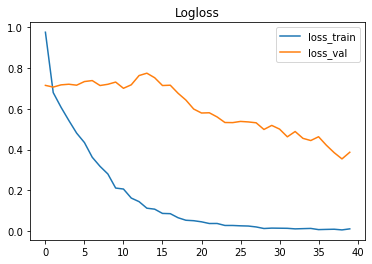

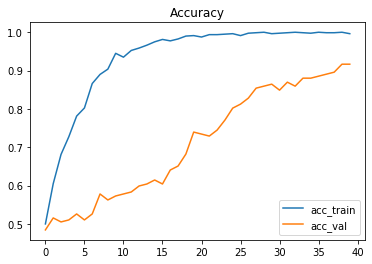

In [54]:
plt.plot(history.history['loss'], label = "loss_train")
plt.plot(history.history['val_loss'], label = "loss_val")
plt.legend()
plt.title("Logloss")
plt.show()

plt.plot(history.history['acc'], label = "acc_train")
plt.plot(history.history['val_acc'], label = "acc_val")
plt.legend()
plt.title("Accuracy")
plt.show()

## Сохраним результаты для дальнейшего анализа 

In [104]:
import pickle
# Модель
#model.save_weights("model.h5")

# Загрузить обратно
# m1 = build_network()
# m1.load_weights("model.h5")

# Кривые обучения
# with open("history.pkl", "wb") as fp:
#     pickle.dump(history.history, fp)

# Загрузить обратно
# with open("history.pkl", "rb") as fp:
#     h1 = pickle.load(fp)

# Разбиение на train/validation
# with open("val_list.pkl", "wb") as fp:
#     pickle.dump(val_list, fp)

# with open("train_list.pkl", "wb") as fp:
#     pickle.dump(train_list, fp)

# Загрузить обратно
# with open("train_list.pkl", "rb") as fp:
#     tr_list = pickle.load(fp)

# with open("val_list.pkl", "rb") as fp:
#     v_list = pickle.load(fp)

## Оценка качества полученного алгоритма классификации

Произведем оценку алгоритма по следующим стандартным для бинарной классификации метрикам:

- Precision
- Recall
- Accuracy
- ROC AUC
- F1-score

Также построим две кривые:

- ROC Curve
- Precision-Recall Curve

In [58]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

test_generator = DataGenerator(val_list, dict_labels, batch_size = 200,  mode = 'val')
val_data = test_generator[0]
pred = model.predict(val_data[0])
true = val_data[1]

VALIDATION_SET_COMPOSITION:
POSITIVE INSTANCES:  100
NEGATIVE INSTANCES:  100


ROC_AUC_SCORE:  0.9633
RECALL_SCORE:  0.86
PRECISION_SCORE:  0.9662921348314607
F1_SCORE:  0.9100529100529101


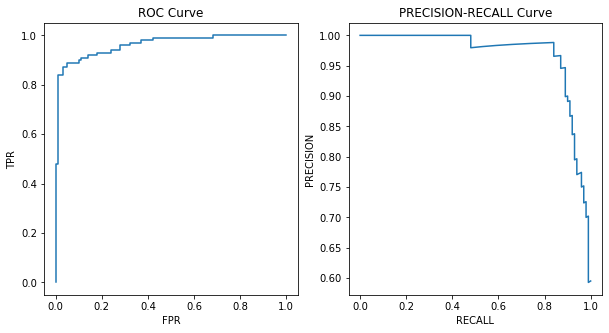

In [90]:
print("VALIDATION_SET_COMPOSITION:")
print("POSITIVE INSTANCES: ", np.sum(true[:, 1] == 1))
print("NEGATIVE INSTANCES: ", np.sum(true[:, 1] == 0))
print('\n')
print("ROC_AUC_SCORE: ", roc_auc_score(true, pred))
print("RECALL_SCORE: ", recall_score(true[:, 1], [1 if x > 0.5 else 0 for x in pred[:, 1]]))
print("PRECISION_SCORE: ",  precision_score(true[:, 1], [1 if x > 0.5 else 0 for x in pred[:, 1]]))
print("F1_SCORE: ", f1_score(true[:, 1], [1 if x > 0.5 else 0 for x in pred[:, 1]]))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(true[:, 1], pred[:, 1])
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

plt.subplot(1, 2, 2)
pre, rec, _ = precision_recall_curve(true[:, 1], pred[:, 1])
plt.plot(rec, pre)
plt.xlabel("RECALL")
plt.ylabel("PRECISION")
plt.title("PRECISION-RECALL Curve")
plt.show()

## Выводы
Результаты вычисления метрик показывают, что модель неплохо решает поставленную задачу классификации. Однако также очевидно, что модель сильно переобучилась на тренировочном наборе данных. Для решения данной проблемы можно предпринять следующие меры:

- Увеличить размер обучающей выборки;
- Уменьшить число параметров в добавленных Fully Connected слоях;
- Заморозить сверточные слои сети или часть из них;
- Добавить регуляризацию для начала на добавленные Fully Connected слои;

## Анализ ошибок алгоритма

Посмотрим, на каких картинках ошибался наш алгоритм классификации.

In [105]:
mistakes = []
for i in range(len(pred)):
    if np.argmax(pred[i]) != np.argmax(val_data[1][i]):
        mistakes.append((i, np.argmax(val_data[1][i])))

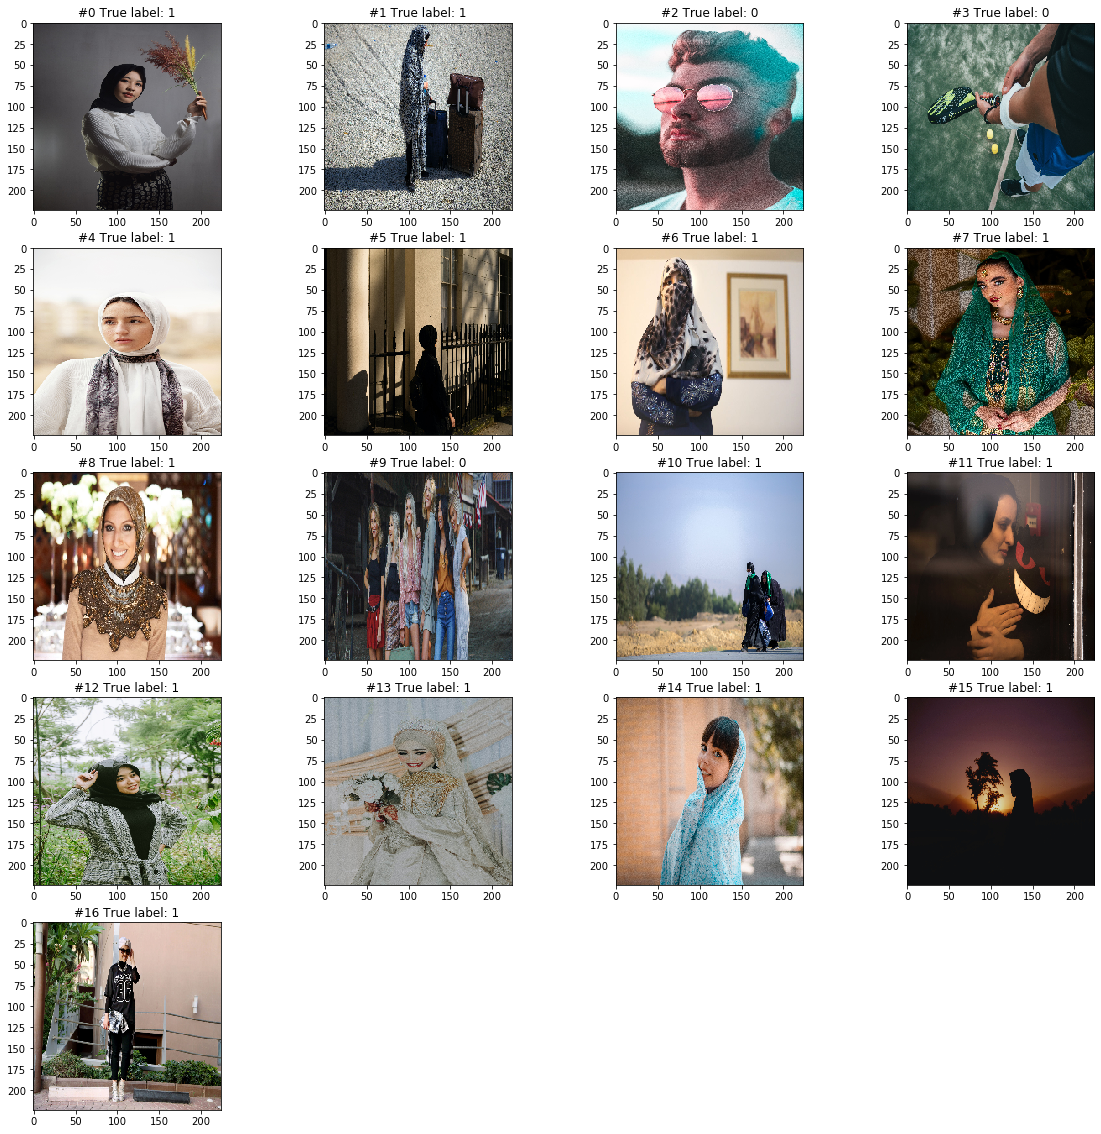

In [106]:
plt.figure(figsize=(20,20))
for j, x in enumerate(mistakes):
    plt.subplot(5, 4, j + 1)
    plt.imshow(val_data[0][x[0]])
    plt.title("#%d True label: %d"%(j, x[1]))
plt.show()

## Комментарий 
Часть картинок являются не совсем типичными для нашего набора данных. К примеру, на изображения с номерами 5, 11 и 15 персонаж сливается с фоном. На снимках 1, 5, 10, 15, 16, возможно, персонаж изображен чуть дальше, чем обычно. На снимке 3 не видно головы персонажа. Также можно предположить, что, поскольку в изображениях хиджаба часто присутствуют сдержанные или даже темные тона, алгоритм мог отнести светлые изображения к отрицательному классу.